# Setup

In [ ]:
%conda install pytorch torchvision torchaudio cudatoolkit = 11.3 - c pytorch
%conda install numpy pandas matplotlib
%pip install opencv-python keyboard Pillow pyautogui wandb

In [6]:
import os
import time
import shutil
import copy
import uuid
import numpy as np
import cv2
import keyboard as kb
from PIL import ImageGrab, ImageFilter
import pyautogui
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import torch
import torchvision
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils, models
import torch.optim as optim
from torch.optim import lr_scheduler

In [7]:
DATA_DIR = 'data'

In [8]:
wandb.login()
wandb.init(project="paper-io-ai", config={
    "batch_size": 16,
    "epochs": 25,
    "learning_rate": 0.0005,
    "momentum": 0.9,
    "step_size": 7,
    "gamma": 0.1
})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eddiezhuang. Use `wandb login --relogin` to force relogin


# Data Collection

In [9]:
# Gets coordinates for bbox
kb.wait('enter')

currentMouseX, currentMouseY = pyautogui.position()
print(f'({currentMouseX}, {currentMouseY})')

(1828, 360)


In [10]:
def shoot_screen():
    screenshot = ImageGrab.grab(bbox=(2, 113, 1275, 1027))
    return screenshot

In [11]:
dir = ''

while True:
    if kb.is_pressed('w'):
        dir = 'w'
    elif kb.is_pressed('a'):
        dir = 'a'
    elif kb.is_pressed('s'):
        dir = 's'
    elif kb.is_pressed('d'):
        dir = 'd'

    if dir != '':
        screenshot = shoot_screen()
        filename = str(uuid.uuid4()) + '.jpg'
        screenshot.save(f'data/{dir}/{filename}')

    if kb.is_pressed('esc'):
        print('Exiting data collection!')
        break

Exiting data collection!


# Training


## Load Data

In [12]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])
data = datasets.ImageFolder(DATA_DIR, data_transform)
class_names = data.classes
device = torch.device("cuda")
torch.cuda.get_device_name(device)

'NVIDIA GeForce GTX 1650'

In [13]:
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(
    data, [train_size, val_size])
image_datasets = {
    'train': train_data,
    'val': val_data
}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=wandb.config.batch_size,
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

## Visualize Images


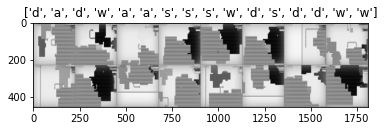

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train the Model


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=wandb.config.epochs):
    wandb.watch(model, log_freq=100)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # load data to GPU
                labels = labels.to(device)

                optimizer.zero_grad()  # clear gradients for this training step

                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate loss
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                wandb.log({"train_loss": epoch_loss, "train_acc": epoch_acc})   
            else:
                wandb.log({"val_loss": epoch_loss, "val_acc": epoch_acc})

            # save the model if it is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_df = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),
                         lr=wandb.config.learning_rate, momentum=wandb.config.momentum)

exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_ft, step_size=wandb.config.step_size, gamma=wandb.config.gamma)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, wandb.config.epochs)

Epoch 1/25
----------
train Loss: 1.1214 Acc: 0.5118
val Loss: 0.8905 Acc: 0.6363

Epoch 2/25
----------
train Loss: 0.6765 Acc: 0.7372
val Loss: 0.6091 Acc: 0.7432

Epoch 3/25
----------
train Loss: 0.4338 Acc: 0.8396
val Loss: 0.4722 Acc: 0.8029

Epoch 4/25
----------
train Loss: 0.2915 Acc: 0.8986
val Loss: 0.4266 Acc: 0.8249

Epoch 5/25
----------
train Loss: 0.2039 Acc: 0.9313
val Loss: 0.3627 Acc: 0.8491

Epoch 6/25
----------
train Loss: 0.1448 Acc: 0.9541
val Loss: 0.3388 Acc: 0.8616

Epoch 7/25
----------
train Loss: 0.0983 Acc: 0.9722
val Loss: 0.3113 Acc: 0.8700

Epoch 8/25
----------
train Loss: 0.0568 Acc: 0.9874
val Loss: 0.2795 Acc: 0.8857

Epoch 9/25
----------
train Loss: 0.0511 Acc: 0.9869
val Loss: 0.2857 Acc: 0.8836

Epoch 10/25
----------
train Loss: 0.0415 Acc: 0.9929
val Loss: 0.2903 Acc: 0.8899

Epoch 11/25
----------
train Loss: 0.0380 Acc: 0.9958
val Loss: 0.2829 Acc: 0.8857

Epoch 12/25
----------
train Loss: 0.0301 Acc: 0.9961
val Loss: 0.2909 Acc: 0.8805

E

## Visualize Model Predictions


In [18]:
def visualize_model(model, num_images=6):
    """Shows predictions for a few images"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():  # Reduces memory consumption for inference
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Returns the max output

            for j in range(inputs.size()[0]):
                images_so_far += 1

                # // divides and only keeps the integer part
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

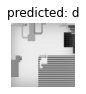

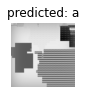

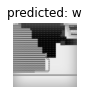

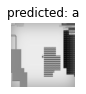

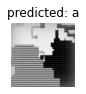

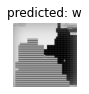

In [19]:
visualize_model(model_ft)

## Save Model


In [20]:
torch.save(model_ft, os.path.join(wandb.run.dir, 'model.pt'))

In [21]:
wandb.finish()

train_acc,▁▄▆▇▇▇███████████████████
train_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇██████████████████
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.99712
train_loss,0.02983
val_acc,0.88365
val_loss,0.28068


# Inference

## Load the Model


In [22]:
model_file = wandb.restore(
    'model.pt', run_path="eddiezhuang/paper-io-ai/2r8wqpoo")

model = torch.load(model_file.name)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Play in Real Time!


In [23]:
def get_pred():
    screenshot = shoot_screen()
    screenshot = data_transform(screenshot).to(device)
    screenshot = screenshot.unsqueeze(0)
    output = model(screenshot)
    _, preds = torch.max(output, 1)
    key = class_names[preds[0]]
    return key

In [25]:
kb.wait('enter')
print('Starting AI playing...')

with torch.no_grad():
    while True:
        key = get_pred()

        kb.send(key)

        if kb.is_pressed('esc'):
            print('Exiting AI playing!')
            break

Starting AI playing...
Exiting AI playing!
